In [26]:
%load_ext autoreload
%autoreload 2
%run ./initializer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) already exists in sys.path


In [27]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from data_loading import DataPreprocessor
from mood_RNN_regression import RNNRegressor, MoodDataset, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

In [ ]:
data_loader = DataPreprocessor()
train_df_split, val_df_split, pred_df = data_loader.load_and_preprocess_data("1d", 0.5, 1, do_bucketing=False)

Removed 24 outliers from 1002 observations. Percentage: 2.40%


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df_split['id'].unique())}
input_dim = train_df_split.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)

In [30]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, device), n_trials=200)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-19 16:26:24,827] A new study created in memory with name: no-name-21d1af6c-32bd-4898-ad07-a5fe25ca32b5
[I 2025-04-19 16:26:24,989] Trial 0 finished with value: 7.140174749202298 and parameters: {'hidden_dim': 127, 'id_embed_dim': 7, 'lr': 0.0016091204432181034, 'batch_size': 128}. Best is trial 0 with value: 7.140174749202298.
[I 2025-04-19 16:26:25,130] Trial 1 finished with value: 49.02159732445738 and parameters: {'hidden_dim': 67, 'id_embed_dim': 14, 'lr': 0.00013052116691146347, 'batch_size': 128}. Best is trial 0 with value: 7.140174749202298.
[I 2025-04-19 16:26:25,255] Trial 2 finished with value: 6.821395796940739 and parameters: {'hidden_dim': 72, 'id_embed_dim': 12, 'lr': 0.00181194643219288, 'batch_size': 128}. Best is trial 2 with value: 6.821395796940739.
[I 2025-04-19 16:26:25,538] Trial 3 finished with value: 34.40096767683674 and parameters: {'hidden_dim': 125, 'id_embed_dim': 9, 'lr': 0.00016556532080063723, 'batch_size': 32}. Best is trial 2 with value: 6.

Best hyperparams: {'hidden_dim': 90, 'id_embed_dim': 15, 'lr': 0.008043821952250464, 'batch_size': 64}


In [31]:
# Final model
model = RNNRegressor(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [32]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=1000)

Epoch 1: train loss = 35.3945, val loss = 11.4038
Epoch 2: train loss = 4.9494, val loss = 1.7650
Epoch 3: train loss = 1.0849, val loss = 0.6984
Epoch 4: train loss = 0.4755, val loss = 0.5735
Epoch 5: train loss = 0.3836, val loss = 0.5234
Epoch 6: train loss = 0.3586, val loss = 0.5383
Epoch 7: train loss = 0.3480, val loss = 0.5010
Epoch 8: train loss = 0.3271, val loss = 0.5147
Epoch 9: train loss = 0.3206, val loss = 0.4980
Epoch 10: train loss = 0.3141, val loss = 0.5076
Epoch 11: train loss = 0.2966, val loss = 0.4980
Epoch 12: train loss = 0.2914, val loss = 0.5229
Epoch 13: train loss = 0.2761, val loss = 0.4877
Epoch 14: train loss = 0.2748, val loss = 0.5709
Epoch 15: train loss = 0.2619, val loss = 0.5230
Epoch 16: train loss = 0.2505, val loss = 0.5613
Epoch 17: train loss = 0.2404, val loss = 0.5656
Epoch 18: train loss = 0.2284, val loss = 0.6183
Epoch 19: train loss = 0.2163, val loss = 0.5933
Epoch 20: train loss = 0.2110, val loss = 0.6268
Epoch 21: train loss = 0.20

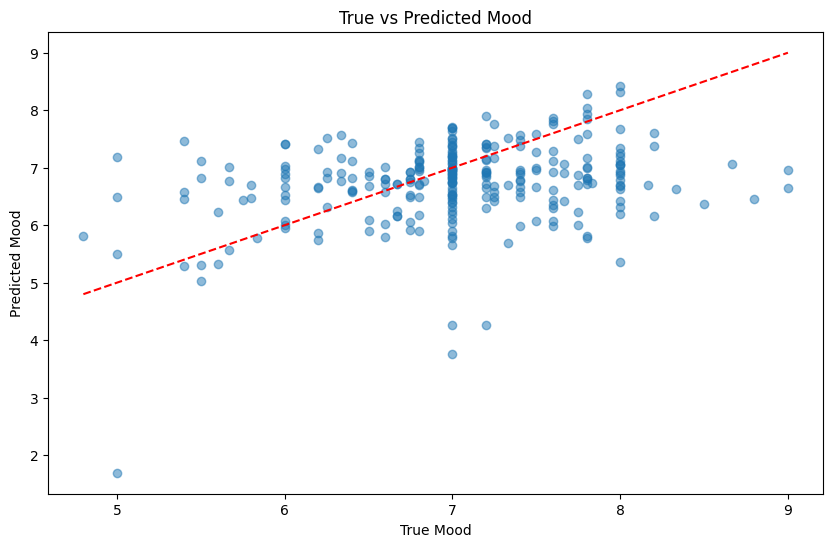

In [33]:
plot_mood_predictions(model, val_loader, device)

In [34]:
# Run predictions on test_df
test_predictions = predict(model, pred_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = pred_df.copy()
test_df_with_preds['predicted_mood'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood']])

         id  predicted_mood
0   AS14.01        6.772830
1   AS14.02        6.537642
2   AS14.03        7.273162
3   AS14.05        5.775200
4   AS14.06        6.167248
5   AS14.07        4.836257
6   AS14.08        7.125448
7   AS14.09        5.926589
8   AS14.12        6.407317
9   AS14.13        7.590767
10  AS14.14        7.284591
11  AS14.15        6.683394
12  AS14.16        6.206960
13  AS14.17        6.255630
14  AS14.19        6.459166
15  AS14.20        6.737356
16  AS14.23        6.770637
17  AS14.24        5.297299
18  AS14.25        6.937524
19  AS14.26        6.102585
20  AS14.27        6.251029
21  AS14.28        7.380898
22  AS14.29        6.143393
23  AS14.30        5.971177
24  AS14.31        7.070444
25  AS14.32        7.170526
26  AS14.33        6.215861
